In [1]:
from pulse_analysis import read_dat
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import csv, matplotlib
%matplotlib widget
matplotlib.rcParams.update({
    'figure.figsize': (13,9),
    'font.size': 18
})

# We first need to create the `read_dat` object that we will use

It only takes one argument: the name of the file we will analyse. For the record, this is data from the 120 mm x 6 mm x 6 mm detector, named SP120. From the PTB run in 2023, at ~19 MeV with ToF. Two SiPMs were used, so I'll show how to get the geometric mean of two pulses.

In [2]:
dat_file = read_dat('example_data.dat')

init complete


# First we just get a file with L and S

In [14]:
baseline_samples = 200                                  # Defining some constants that the analysis will use
start = -30                                             # These are in units of samples
short = 75
long = 1000
cfd_frac = 0.75
cfd_offset = 6

write_file = open('example_data_L_S.csv', 'w')         # Open a file in "write" mode
csv_writer = csv.writer(write_file)                     # Create a csv writer object
csv_writer.writerow(['L', 'S'])           # Write the header line to it with the names of the columns we'll use

counter = 0                                             # Used to keep track of how many events we've processed. Just for display

num_events = 10000

for i in range(num_events):                             # Here we process a specified number of events. Later we will process the entire file

    read_traces = dat_file.read_event(baseline_samples)                 # We read in all the traces. This may change so you can specify which channels to read     

    cfd_0 = dat_file.cfd(read_traces[0][0], cfd_frac, cfd_offset)[1]    # Run the cfd method on the trace we want to use. This returns many things but we choose to use only the zero-crossover time in integer samples

    integrals_0 = dat_file.calculate_integrals(read_traces[0][0], cfd_0, start, short, long)    # Calculate the integrals. Be aware that this is not L and S, but L and the short integral.

    csv_writer.writerow([integrals_0[1], integrals_0[0]/integrals_0[1]])    # We have to calculate S from L and the short integral, and write it to the next line in the csv

    counter += 1

    if counter % 1000 == 0:                             # This is only to show the progress. Not strictly necessary
        print(f'{counter} events')

print('Finished...')

write_file.close()



1000 events
2000 events
3000 events
4000 events
5000 events
6000 events
7000 events
8000 events
9000 events
10000 events
Finished...


# Next we can import that data from the file and plot it

One can, of course, choose to just save the L and S values to arrays in the previous cell and plot there, but that requires re-running the whole thing when you want to do it again, so I recommend this method in most cases.

In [3]:
file = open(f'./example_data_L_S.csv', 'r')                 # Open the file in "read" mode

reader = csv.reader(file)                                   # We're using csv again as it's quite good at this

head = next(reader, None)                                   # Reads the header. Of course if you didn't include a header you won't need this. I find it's a nice check
print(head)

L = []
S = []

for row in reader:
    L.append(float(row[0]))
    S.append(float(row[1]))

file.close()

L = np.array(L)                                             # I like numpy arrays. You don't have to like numpy arrays
S = np.array(S)


['L', 'S']


# Then we can plot them

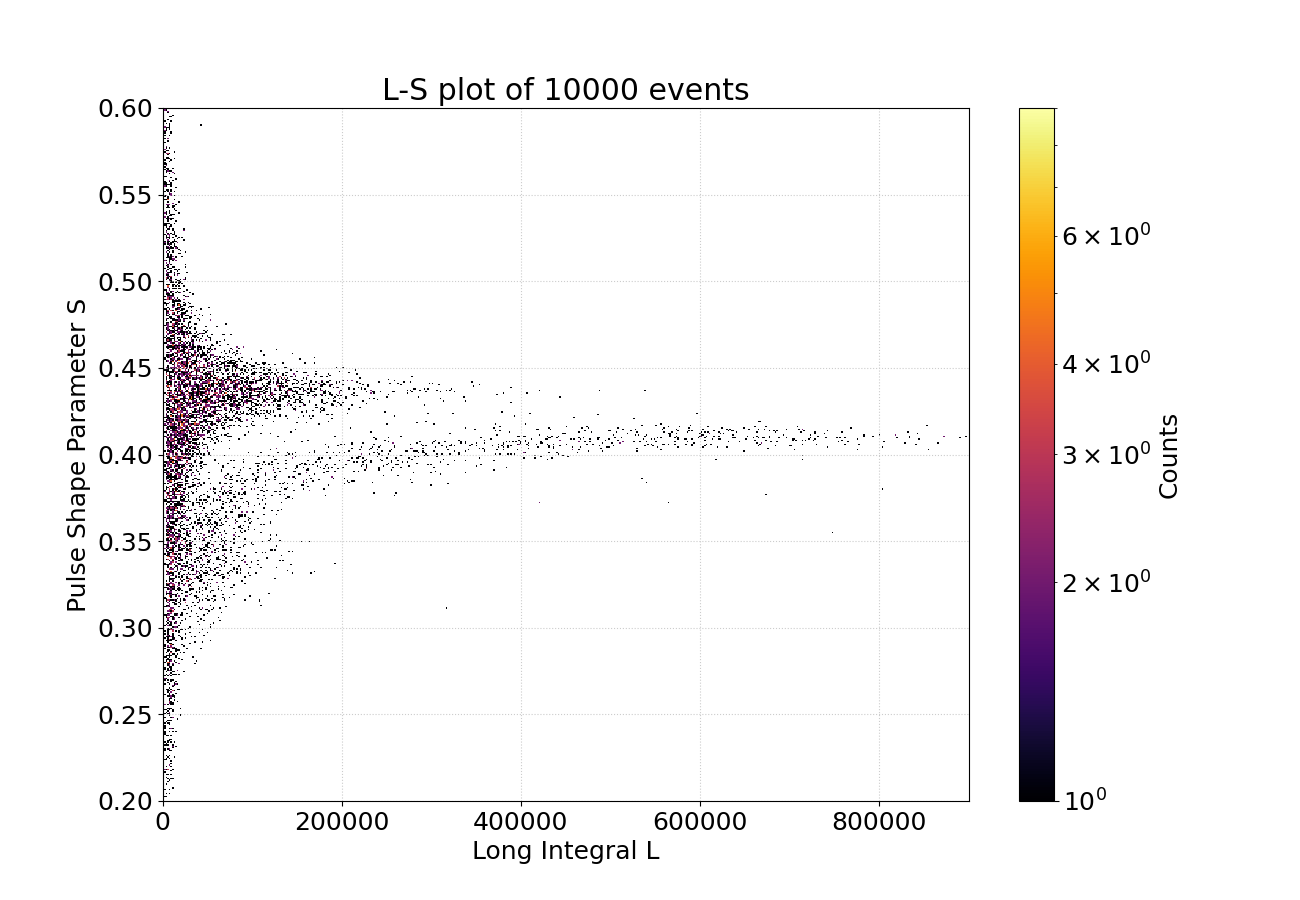

In [4]:
plt.figure()

plt.hist2d(L, S, bins=[512,512], cmap='inferno', norm=colors.LogNorm(vmin=1), range=((0, 900001), (0.2, 0.6)))

plt.xlabel('Long Integral L')
plt.ylabel('Pulse Shape Parameter S')

plt.title(f'L-S plot of 10000 events')
plt.grid(color='#CCCCCC', linestyle=':')
plt.colorbar(label='Counts')
plt.show()

# The next thing you might want to do is put a cut on these data

To do this, we use the `draw_polygons` method. I'd recommend playing around with plotting the data first to get an idea of the right limits to use in this next section. The ones I've chosen aren't particularly good as the neutron locus extends past the range of L.

This is where things can get a bit finnicky. I've got this working with jupyter notebooks, using the `%matplotlib widget` visualisation backend. This may not work for you, in which case I recommend switching to using `%matplotlib tk`. This will require a restart of the kernel however, as matplotlib doesn't like switching on the fly.

Once the below cell has been run, a plot similar to the one above will appear and you will be able to draw polygons on it. Below are the key-presses that do certain things. Note if you're using `%matplotlib widget` then you need to first click on the plot before the key-presses will register.

| Key&nbsp;&nbsp; | Action    |
|---    |---    |
| a, A  | Start a new selection   |
| u, U  | Undo previous point, only usable while in a selection |
| x, X  | End current selection. Can only end a selection if there are more than 2 co-ordinates in the selection    |
| d, D  | Delete previous completed selection   |
| o, O  | Output the selections added to the file name specified  |
| q, Q  | Quit, ends visual guide and re-enters the main code segment. Doesn't really work with `%matplotlib widget`   |

A typical selection would proceed as follows:
- Press "a" to start the selection.
- Choose at least 3 coordinates to enclose an area. If less than 3 are chosen before the next step, it will throw an error.
- Press "x" to end the selection. 
- If you want to export the selection so it can be used again later, press "o".
- Finally press "q" to quit.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


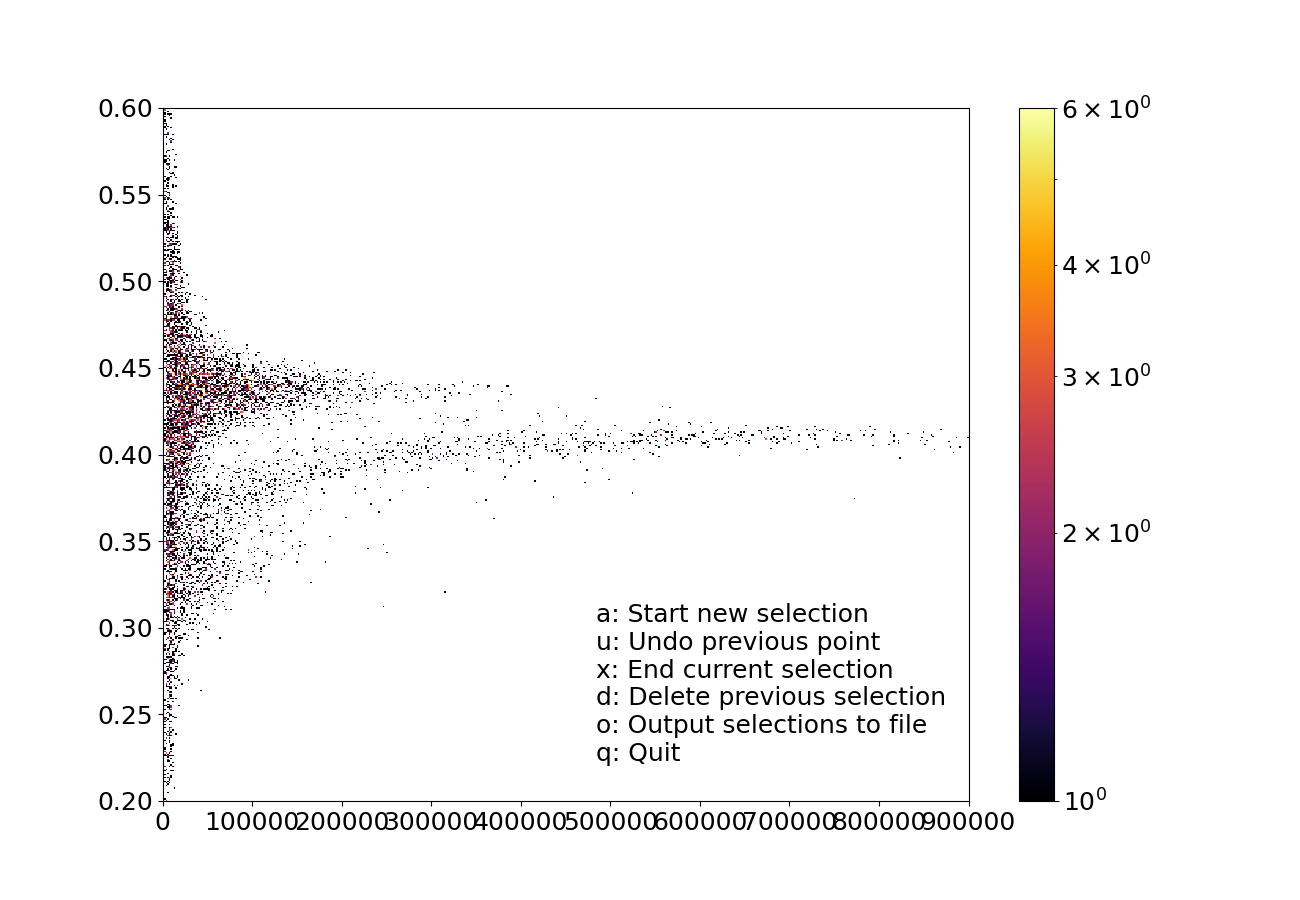

Begin selection for cut 1
771029.7766749379 0.4274170274170275
238399.50372208437 0.42568542568542567
77605.45905707197 0.4112554112554113
36290.32258064518 0.38528138528138534
17307.692307692312 0.3656565656565657
558.3126550868619 0.3621933621933622
882692.3076923076 0.20634920634920637
3908.188585607946 0.20230880230880233
898325.0620347395 0.2028860028860029
888275.4342431762 0.42914862914862917
794478.9081885855 0.4274170274170275
End selection
Selections outputted to file: example_data_cuts.csv


In [4]:
dat_file.draw_polygons(L, S, 'example_data_L_S_cuts', [[0, 900000], [0.2, 0.6]])

# Then we can import that polygon

This seems convoluted but again it allows for you to create the polygons you need in order to cut certain things out, and then use them again and again.

In [4]:
neutron_cut = dat_file.read_polygons('example_data_L_S_cuts.csv')           # This function returns one polygon if only one is in the file, or an array if many are in the file

# Now we can use that polygon to define a mask array

We can use this mask on any array that is in the same order as the L and S arrays. I will show this off later

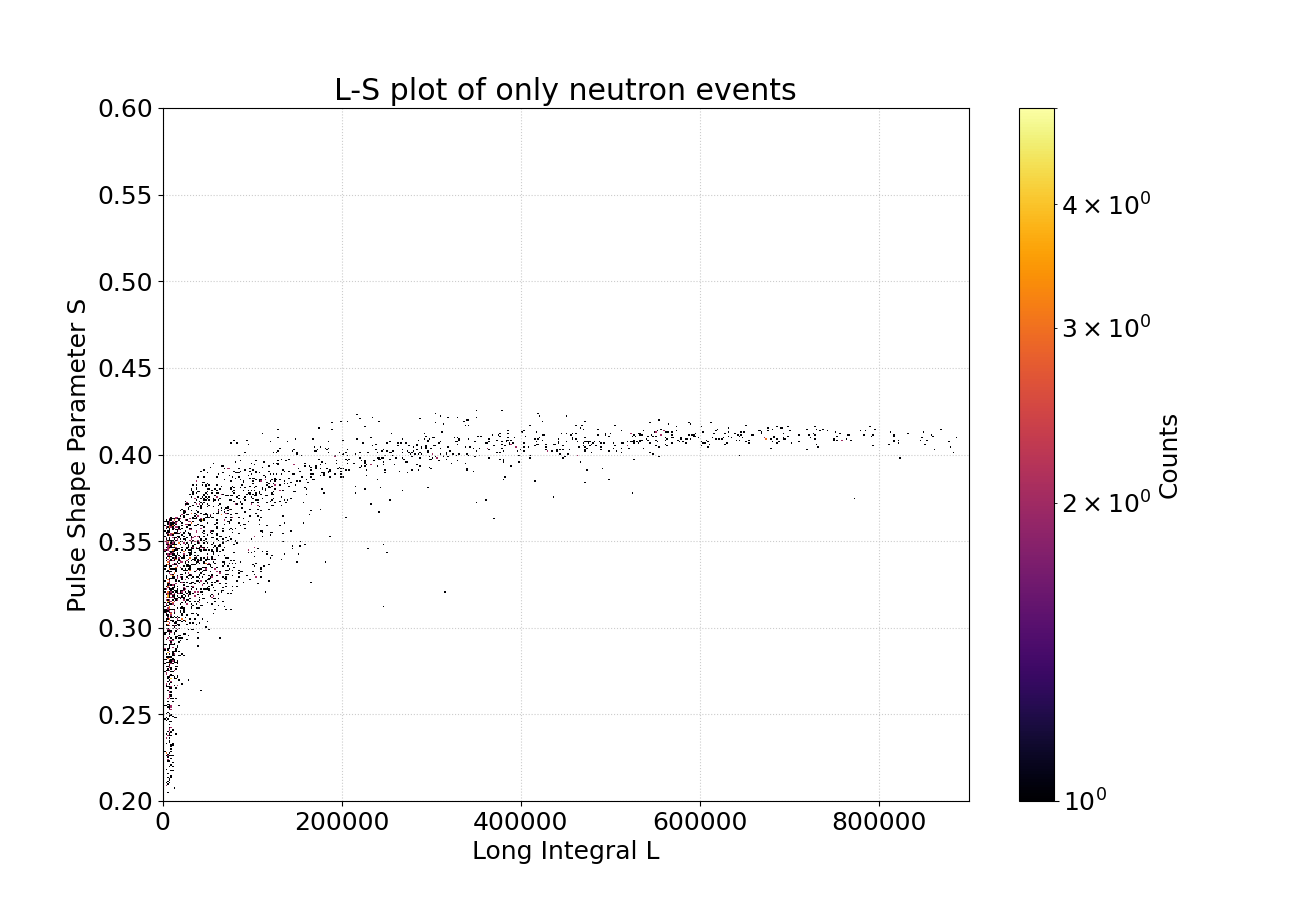

In [8]:
neutron_cut_mask = neutron_cut.contains_points(np.transpose([L, S]))            # Note the transposition. This is just due to how the contains_points function works

plt.figure()

plt.hist2d(L[neutron_cut_mask], S[neutron_cut_mask], bins=[512,512], cmap='inferno', norm=colors.LogNorm(vmin=1), range=((0, 900001), (0.2, 0.6)))

plt.xlabel('Long Integral L')
plt.ylabel('Pulse Shape Parameter S')

plt.title(f'L-S plot of only neutron events')
plt.grid(color='#CCCCCC', linestyle=':')
plt.colorbar(label='Counts')
plt.show()


# Now we can get into the interesting stuff. We'll start with the geometric mean

In [11]:
dat_file.reinitialise_file()            # This ensures we're starting reading data from the beginning of the file, not 10000 events in

# These data could of course be imported again and plotted but you know how to do that

In [3]:
baseline_samples = 200
start = -30
short = 75
long = 1000
cfd_frac = 0.75
cfd_offset = 6

write_file = open('example_data_geo_mean.csv', 'w')
csv_writer = csv.writer(write_file)
csv_writer.writerow(['L geo_mean', 'S geo_mean'])

counter = 0


for i in range(10000):
    read_traces = dat_file.read_event(baseline_samples)                 # We still read in all channels

    cfd_0 = dat_file.cfd(read_traces[0][0], cfd_frac, cfd_offset)[1]       # We need to do this so the traces line up correctly
    cfd_1 = dat_file.cfd(read_traces[0][1], cfd_frac, cfd_offset)[1]

    geo_mean_trace = dat_file.get_geometric_mean_trace(read_traces[0][:2], [cfd_0, cfd_1])     # Takes the two traces and their alignment points, in order
    geo_mean_cfd = dat_file.cfd(geo_mean_trace, cfd_frac, cfd_offset)[1]                    # Calculating the cfd point of the new trace
    geo_mean_integrals = dat_file.calculate_integrals(geo_mean_trace, geo_mean_cfd, start, short, long)     # Calculating the integrals from the new trace

    csv_writer.writerow([geo_mean_integrals[1], geo_mean_integrals[0]/geo_mean_integrals[1]])       # Writing to file

    counter += 1

    if counter % 1000 == 0:
        print(f'{counter} events')

print('Finished...')

write_file.close()

1000 events
2000 events
3000 events
4000 events
5000 events
6000 events
7000 events
8000 events
9000 events
10000 events
Finished...


# The last fun thing is the time of flight

Usually I would do the L and S of each channel, the geometric mean, and the tof all in one go to save on computation. This is just for show.

In [18]:
baseline_samples = 200
start = -30
short = 75
long = 1000
cfd_frac = 0.75
cfd_offset = 6

write_file = open('example_data_tof.csv', 'w')
csv_writer = csv.writer(write_file)
csv_writer.writerow(['geo_mean_tof'])

counter = 0


for i in range(10000):
    read_traces = dat_file.read_event(baseline_samples)

    cfd_0 = dat_file.cfd(read_traces[0][0], cfd_frac, cfd_offset)[1]
    cfd_1 = dat_file.cfd(read_traces[0][1], cfd_frac, cfd_offset)[1]

    geo_mean_trace = dat_file.get_geometric_mean_trace(read_traces[0][:2], [cfd_0, cfd_1])
    geo_mean_cfd = dat_file.cfd(geo_mean_trace, cfd_frac, cfd_offset)[1]
    geo_mean_tof = dat_file.time_of_flight(read_traces[0][0], read_traces[0][2], 350, 5000, (cfd_frac, cfd_offset))       # The two numbers supplied here are explained in the docstring for this method

    csv_writer.writerow([geo_mean_tof])

    counter += 1

    if counter % 1000 == 0:
        print(f'{counter} events')

print('Finished...')

write_file.close()

1000 events
2000 events
3000 events
4000 events
5000 events
6000 events
7000 events
8000 events
9000 events
10000 events
Finished...


# And then you can turn this into an energy spectrum like this

In [ ]:
file = open(f'./example_data_tof.csv', 'r')

reader = csv.reader(file)

head = next(reader, None)
print(head)

L_for_tof = []
S_for_tof = []
tof_samples = []

for row in reader:
    L_for_tof.append(float(row[0]))
    S_for_tof.append(float(row[1]))
    tof_samples.append(float(row[2]))

file.close()

L_for_tof = np.array(L_for_tof)
S_for_tof = np.array(S_for_tof)
tof_samples = np.array(tof_samples)

# Converts to a time between pulses instead of a number of samples
tof_ns = tof_samples * 2

In [ ]:
gamma_peak_time = 1500
dist_to_target = 12     # m
c = 299792458           # m/s
m_neutron = 939.565     # MeV

gamma_peak = gamma_peak_time
gamma_time_to_target = dist_to_target / (c * 1e-9)


tof_shifted = tof_ns - (gamma_peak + gamma_time_to_target)
# Now the time that the proton hits the target should be at t = 0 
# But the whole spectrum is still going negative
tof_shifted_flipped = tof_shifted * -1

v = dist_to_target / (tof_shifted_flipped * 1e-9)

# Returns energy in MeV
E_neutron = m_neutron * ( ( 1 / (np.sqrt( 1 - ((v**2) / (c**2)) ) ) ) - 1 )

# Now if you want to process all events

In [ ]:
baseline_samples = 200
start = -30
short = 75
long = 1000
cfd_frac = 0.75
cfd_offset = 6

write_file = open('example_data_L_S_all.csv', 'w')
csv_writer = csv.writer(write_file)
csv_writer.writerow(['L', 'S'])

counter = 0

while True:

    if dat_file.get_end_of_file() == True:
        break

    read_traces = dat_file.read_event(baseline_samples)

    cfd_0 = dat_file.cfd(read_traces[0][0], cfd_frac, cfd_offset)[1]

    integrals_0 = dat_file.calculate_integrals(read_traces[0][0], cfd_0, start, short, long)

    csv_writer.writerow([integrals_0[1], integrals_0[0]/integrals_0[1]])

    counter += 1

    if counter % 1000 == 0
        print(f'{counter} events')

print('Finished...')

write_file.close()